In [97]:
import sys
bin_path = '../../functions'
if bin_path not in sys.path:
    sys.path.insert(1, '../../functions')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'arial',
        'size'   : 15}
matplotlib.rc('font', **font)
import seaborn as sns
sns.set(style = 'whitegrid', font_scale = 1.5)


import format_data as fd

### Function for filtering data and combining into superlineages

In [127]:
def coarse_grained_lineages(counts_all, total_sampled_counts):
    
    # Drop times that are not every delta t interval
    lineage_col_name = 'lineage'
    delta_t = 1
    T = 9
    epiweeks_all = counts_all.drop([lineage_col_name], axis = 1).columns
    epiweeks_all_updated = epiweeks_all[::delta_t]
    epiweeks_to_drop = np.array([epiweek for epiweek in epiweeks_all if epiweek not in epiweeks_all_updated])
    counts_all.drop(labels = epiweeks_to_drop, axis = 'columns', inplace =True)
    total_sampled_counts_all.drop(labels = epiweeks_to_drop, axis = 'columns', inplace =True)
    epiweeks_all = epiweeks_all_updated
    T = int((T-1)/delta_t+1)

    # Renaming epiweek format (easier to work with later on)
    epiweeks_all_rename_dict = {}
    for epiweek in epiweeks_all:
        epiweeks_all_rename_dict[epiweek] = str(float(epiweek))
    counts_all.rename(columns = epiweeks_all_rename_dict, inplace = True)
    total_sampled_counts_all.rename(columns = epiweeks_all_rename_dict, inplace = True)
    epiweeks_all = counts_all.drop([lineage_col_name], axis = 1).columns

    mincount = 20
    minfreq = 0.01

    # Get dataframes of the frequencies for each time window
    # Looping through time windows
    f_all = []
    for i in range(len(epiweeks_all)-(T-1)):
        epiweeks = epiweeks_all[i:i+T]
        print(str(i+1) + ' out of ' + str(len(epiweeks_all)-(T-1)) + ' times')
        d1=epiweeks[0]
        dl=epiweeks[-1]

        # Get data from this time window
        counts = counts_all[epiweeks]
        counts = counts.loc[~(counts==0).all(axis=1)] # Drop any lineages that have 0 counts throughout the time window

        counts_original = counts.copy()
        total_sampled_counts = total_sampled_counts_all[epiweeks]

        # Creating superlineages and formatting the data
        counts, frequency = fd.create_superlineages_counts_and_freq(counts_original, total_sampled_counts, d1, dl, mincount, minfreq, seed = np.random.randint(10**5))

        if len(frequency)>0:
            f_all.append(frequency[epiweeks])
    return f_all

### Correct with inferred Ne values and plot

In [134]:
def plot_distribution(f_all, summary):
    bins = np.arange(-6, 6, 0.2)
    A = np.array([])
    B = np.array([])
    for f in f_all:
        epiweeks = f.columns
        epiweek_mid = epiweeks[4]
        Ne = summary[summary['Epiweek']==float(epiweek_mid)]['Netau_HMM_median'].values[0]
        for i in range(len(epiweeks)-1):
            epiweek1 = epiweeks[i]
            epiweek2 = epiweeks[i+1]
            if (float(epiweek1) in summary['Epiweek'].values)&(float(epiweek2) in summary['Epiweek'].values):
                c1 = summary[summary['Epiweek']==float(epiweek1)]['c_median'].values[0]
                c2 = summary[summary['Epiweek']==float(epiweek2)]['c_median'].values[0]
                M1 = total_sampled_counts_all[epiweek1].values[0]
                M2 = total_sampled_counts_all[epiweek2].values[0]
                denom = 0.5*np.sqrt(c1/M1+c2/M2+1/Ne)
                f_epiweek = f[[epiweek1, epiweek2]].values
                A = np.concatenate((A, (np.diff(np.sqrt(f_epiweek))/denom).flatten()))
    fig = plt.figure(figsize = (5.5,4.5))
    plt.hist(A, bins = bins, density = True)

    x = np.arange(-6, 6, 0.1)
    plt.plot(x, norm.pdf(x, 0, 1), label = '$\mathcal{N}(\mu=0,v=1)$')
    plt.yscale('log')
    plt.ylim([10**-4, 10**0.5])
    plt.xlabel('$\\frac{\sqrt{f_{t+1}^{obs}}-\sqrt{f_{t}^{obs}}}{\sqrt{\kappa_{t,t+1}}}$')
    plt.ylabel('Probability')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return fig

### Functions for calculating squared deviation and plotting mean squared displacement

In [151]:
def calculate_sd(f_all, summary):
    bins = np.arange(-6, 6, 0.2)
    SD_all = {1:np.array([]), 2:np.array([]), 3:np.array([]), 4:np.array([]), 5:np.array([]), 6:np.array([]), 7:np.array([]), 8:np.array([])}
    SD_all_lower = {1:np.array([]), 2:np.array([]), 3:np.array([]), 4:np.array([]), 5:np.array([]), 6:np.array([]), 7:np.array([]), 8:np.array([])}
    SD_all_upper = {1:np.array([]), 2:np.array([]), 3:np.array([]), 4:np.array([]), 5:np.array([]), 6:np.array([]), 7:np.array([]), 8:np.array([])}
        
    for f in f_all:
        epiweeks = f.columns
        epiweek_mid = epiweeks[4]
        Ne = summary[summary['Epiweek']==float(epiweek_mid)]['Netau_HMM_median'].values[0]
        Ne_lower = summary[summary['Epiweek']==float(epiweek_mid)]['Netau_HMM_95%_ci_lower'].values[0]
        Ne_upper = summary[summary['Epiweek']==float(epiweek_mid)]['Netau_HMM_95%_ci_upper'].values[0]
        if not np.isnan(Ne):
            for i in range(len(epiweeks)):
                for j in range(i+1, len(epiweeks)):
                    epiweek1 = epiweeks[i]
                    epiweek2 = epiweeks[j]
                    deltat = float(epiweek2)-float(epiweek1)
                    if (float(epiweek1) in summary['Epiweek'].values)&(float(epiweek2) in summary['Epiweek'].values):
                        c1 = summary[summary['Epiweek']==float(epiweek1)]['c_median'].values[0]
                        c2 = summary[summary['Epiweek']==float(epiweek2)]['c_median'].values[0]
                        c1_lower = summary[summary['Epiweek']==float(epiweek1)]['c_95%_ci_lower'].values[0]
                        c1_upper = summary[summary['Epiweek']==float(epiweek1)]['c_95%_ci_upper'].values[0]
                        c2_lower = summary[summary['Epiweek']==float(epiweek2)]['c_95%_ci_lower'].values[0]
                        c2_upper = summary[summary['Epiweek']==float(epiweek2)]['c_95%_ci_upper'].values[0]
                        M1 = total_sampled_counts_all[epiweek1].values[0]
                        M2 = total_sampled_counts_all[epiweek2].values[0]
                        SD_all[deltat] = np.concatenate((SD_all[deltat], 4*Ne*((np.sqrt(f[epiweek2].values)-np.sqrt(f[epiweek1].values))**2-c1/(4*M1)-c2/(4*M2))))
                        SD_all_lower[deltat] = np.concatenate((SD_all_lower[deltat], 4*Ne*((np.sqrt(f[epiweek2].values)-np.sqrt(f[epiweek1].values))**2-c1_lower/(4*M1)-c2_lower/(4*M2))))
                        SD_all_upper[deltat] = np.concatenate((SD_all_upper[deltat], 4*Ne*((np.sqrt(f[epiweek2].values)-np.sqrt(f[epiweek1].values))**2-c1_upper/(4*M1)-c2_upper/(4*M2))))
    return SD_all, SD_all_lower, SD_all_upper

def plot_MSD(SD_all, SD_all_lower, SD_all_upper):
    MSD = []
    MSD_lower = []
    MSD_upper = []
    sem = []
    for i in SD_all:
        MSD.append(np.nanmean(SD_all[i]))
        MSD_lower.append(np.nanmean(SD_all_lower[i]))
        MSD_upper.append(np.nanmean(SD_all_upper[i]))
        sem.append(np.nanstd(SD_all[i])/np.sqrt(len(SD_all[i])))

    fig = plt.figure(figsize = (9,4))
    plt.errorbar(list(SD_all.keys()), MSD, marker = 'o', yerr = sem, label = '$c_t$ point estimate')
    plt.plot(list(SD_all_lower.keys()), MSD_lower, marker = 'o', label = '$c_t$ lower CI')
    plt.plot(list(SD_all_upper.keys()), MSD_upper, marker = 'o', label = '$c_t$ upper CI')

    plt.plot([0, 10],[0, 10], 'k:', label = '1:1')
    plt.xlim([0,10])

    plt.xlabel('Time difference (epiweeks)')
    plt.ylabel('Mean squared \ndisplacement')
    plt.legend(loc = (1.01, 0))
    plt.tight_layout()
    plt.show()
    return fig

### Plotting square root difference in frequency

In [152]:
def plot_sqrt_f_diff(f_all):
    fig = plt.figure(figsize = (5.5,4))
    for f in f_all:
        epiweeks = f.columns
        plt.scatter(f[epiweeks[:-1]], np.diff(np.sqrt(f)), marker = '.', alpha = 0.3, color = 'k')
    plt.plot([10**-2, 10**-2],[-0.9, 0.6], 'k--')
    plt.xscale('log')
    plt.xlabel('$f_t$')
    plt.ylabel('$\sqrt{f_{t+1}}$-$\sqrt{f_t}$')
    plt.ylim([-0.5, 0.5])
    plt.tight_layout()
    plt.show()
    return fig

### Run

1 out of 33 times
2 out of 33 times
3 out of 33 times
4 out of 33 times
5 out of 33 times
6 out of 33 times
7 out of 33 times
8 out of 33 times
9 out of 33 times
10 out of 33 times
11 out of 33 times
12 out of 33 times
13 out of 33 times
14 out of 33 times
15 out of 33 times
16 out of 33 times
17 out of 33 times
18 out of 33 times
19 out of 33 times
20 out of 33 times
21 out of 33 times
22 out of 33 times
23 out of 33 times
24 out of 33 times
25 out of 33 times
26 out of 33 times
27 out of 33 times
28 out of 33 times
29 out of 33 times
30 out of 33 times
31 out of 33 times
32 out of 33 times
33 out of 33 times


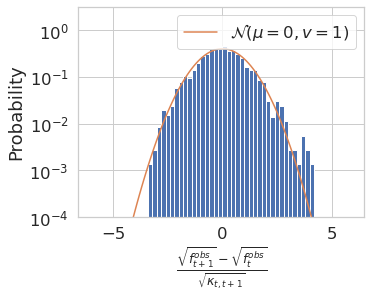

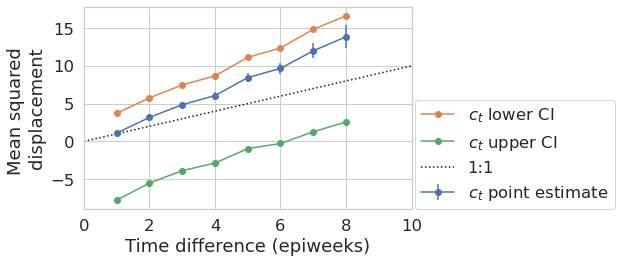

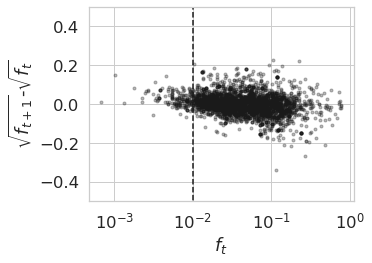

1 out of 83 times
2 out of 83 times
3 out of 83 times
4 out of 83 times
5 out of 83 times
6 out of 83 times
7 out of 83 times
8 out of 83 times
9 out of 83 times
10 out of 83 times
11 out of 83 times
12 out of 83 times
13 out of 83 times
14 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)
/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)
/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)
/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiwee

15 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)


16 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)


17 out of 83 times
18 out of 83 times
19 out of 83 times
20 out of 83 times
21 out of 83 times
22 out of 83 times
23 out of 83 times
24 out of 83 times
25 out of 83 times
26 out of 83 times
27 out of 83 times
28 out of 83 times
29 out of 83 times
30 out of 83 times
31 out of 83 times
32 out of 83 times
33 out of 83 times
34 out of 83 times
35 out of 83 times
36 out of 83 times
37 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)


38 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)


39 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)


40 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)


41 out of 83 times
42 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)
/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)


43 out of 83 times
44 out of 83 times
45 out of 83 times
46 out of 83 times
47 out of 83 times
48 out of 83 times
49 out of 83 times
50 out of 83 times
51 out of 83 times
52 out of 83 times
53 out of 83 times
54 out of 83 times
55 out of 83 times
56 out of 83 times
57 out of 83 times
58 out of 83 times
59 out of 83 times
60 out of 83 times
61 out of 83 times
62 out of 83 times
63 out of 83 times
64 out of 83 times
65 out of 83 times
66 out of 83 times
67 out of 83 times
68 out of 83 times
69 out of 83 times
70 out of 83 times
71 out of 83 times
72 out of 83 times
73 out of 83 times
74 out of 83 times
75 out of 83 times
76 out of 83 times
77 out of 83 times
78 out of 83 times
79 out of 83 times
80 out of 83 times
81 out of 83 times
82 out of 83 times
83 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)
/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)


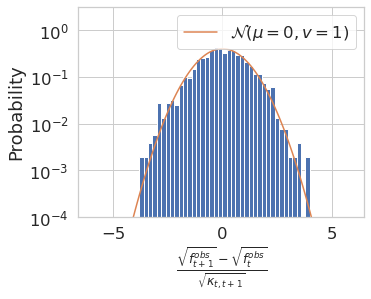

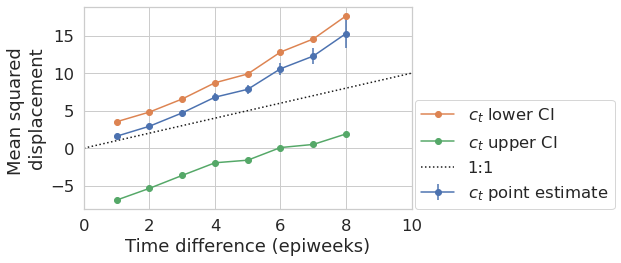

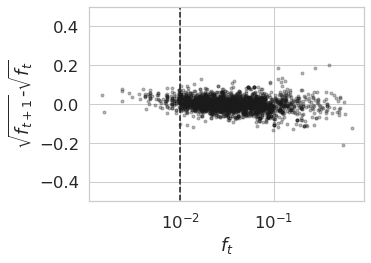

1 out of 83 times
2 out of 83 times
3 out of 83 times
4 out of 83 times
5 out of 83 times
6 out of 83 times
7 out of 83 times
8 out of 83 times
9 out of 83 times
10 out of 83 times
11 out of 83 times
12 out of 83 times
13 out of 83 times
14 out of 83 times
15 out of 83 times
16 out of 83 times
17 out of 83 times
18 out of 83 times
19 out of 83 times
20 out of 83 times
21 out of 83 times
22 out of 83 times
23 out of 83 times
24 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)
/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)
/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)
/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiwee

25 out of 83 times
26 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)


27 out of 83 times
28 out of 83 times
29 out of 83 times
30 out of 83 times
31 out of 83 times
32 out of 83 times
33 out of 83 times
34 out of 83 times
35 out of 83 times
36 out of 83 times
37 out of 83 times
38 out of 83 times
39 out of 83 times
40 out of 83 times
41 out of 83 times
42 out of 83 times
43 out of 83 times
44 out of 83 times
45 out of 83 times
46 out of 83 times
47 out of 83 times
48 out of 83 times
49 out of 83 times
50 out of 83 times
51 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)


52 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)


53 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)


54 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)


55 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)


56 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)


57 out of 83 times
58 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)
/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)


59 out of 83 times
60 out of 83 times
61 out of 83 times
62 out of 83 times
63 out of 83 times
64 out of 83 times
65 out of 83 times
66 out of 83 times
67 out of 83 times
68 out of 83 times
69 out of 83 times
70 out of 83 times
71 out of 83 times
72 out of 83 times
73 out of 83 times
74 out of 83 times
75 out of 83 times
76 out of 83 times
77 out of 83 times
78 out of 83 times
79 out of 83 times
80 out of 83 times
81 out of 83 times
82 out of 83 times
83 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)
/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)
/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)
/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiwee

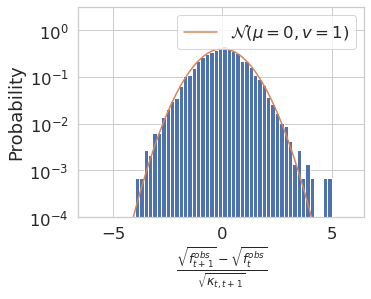

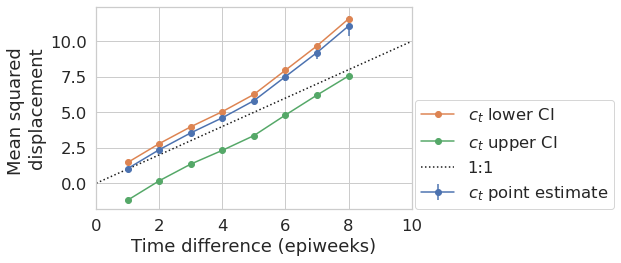

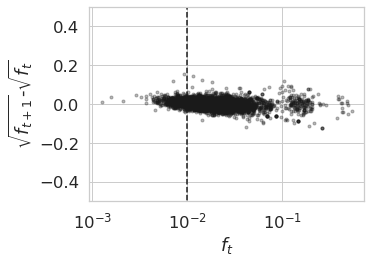

1 out of 83 times
2 out of 83 times
3 out of 83 times
4 out of 83 times
5 out of 83 times
6 out of 83 times
7 out of 83 times
8 out of 83 times
9 out of 83 times
10 out of 83 times
11 out of 83 times
12 out of 83 times
13 out of 83 times
14 out of 83 times
15 out of 83 times
16 out of 83 times
17 out of 83 times
18 out of 83 times
19 out of 83 times
20 out of 83 times
21 out of 83 times
22 out of 83 times
23 out of 83 times
24 out of 83 times
25 out of 83 times
26 out of 83 times
27 out of 83 times
28 out of 83 times
29 out of 83 times
30 out of 83 times
31 out of 83 times
32 out of 83 times
33 out of 83 times
34 out of 83 times
35 out of 83 times
36 out of 83 times
37 out of 83 times
38 out of 83 times
39 out of 83 times
40 out of 83 times
41 out of 83 times
42 out of 83 times
43 out of 83 times
44 out of 83 times
45 out of 83 times
46 out of 83 times
47 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)
/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)
/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)
/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiwee

48 out of 83 times
49 out of 83 times


/global/u2/q/qinqinyu/projects/sars-cov-2_genetic_drift/analysis_scripts/model_checking/../../functions/format_data.py:20: RuntimeWarning: invalid value encountered in divide
  neutral_frequency = (counts[epiweeks].values/total_counts[epiweeks].values)


50 out of 83 times
51 out of 83 times
52 out of 83 times
53 out of 83 times
54 out of 83 times
55 out of 83 times
56 out of 83 times
57 out of 83 times
58 out of 83 times
59 out of 83 times
60 out of 83 times
61 out of 83 times
62 out of 83 times
63 out of 83 times
64 out of 83 times
65 out of 83 times
66 out of 83 times
67 out of 83 times
68 out of 83 times
69 out of 83 times
70 out of 83 times
71 out of 83 times
72 out of 83 times
73 out of 83 times
74 out of 83 times
75 out of 83 times
76 out of 83 times
77 out of 83 times
78 out of 83 times
79 out of 83 times
80 out of 83 times
81 out of 83 times
82 out of 83 times
83 out of 83 times


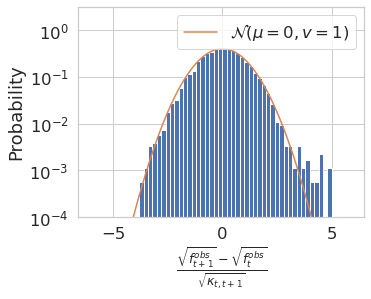

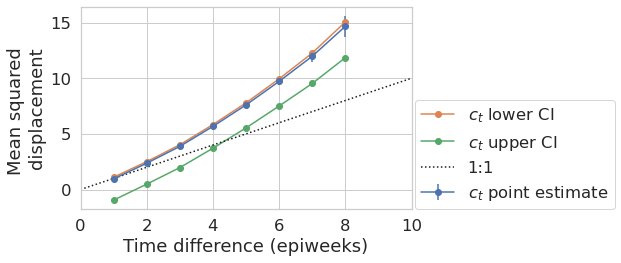

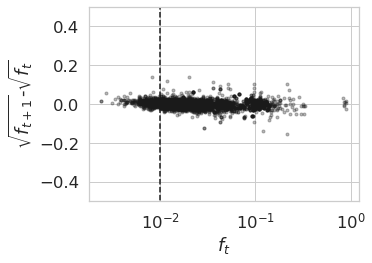

In [153]:
# Load data
variant_param_folders = ['../../data/lineages/pre_B-1-177/microreact/is_pillar_2/England/',
                         '../../data/lineages/B-1-177/B-1-177|2021-02-22|694.5/is_pillar_2/England/',
                         '../../data/lineages/alpha/alpha|2021-06-20|61.5/is_pillar_2/England/',
                         '../../data/lineages/delta/delta|2022-01-25|49.5+58.5/is_pillar_2/England/']

variant = ['pre_B-1-177', 'B-1-177', 'alpha', 'delta']
i = 0
for variant_param_folder in variant_param_folders:
    counts_all = pd.read_csv(variant_param_folder + 'counts_lineages.csv', index_col = 0)
    total_sampled_counts_all = pd.read_csv(variant_param_folder + 'total_counts_lineages.csv', index_col = 0)
    summary = pd.read_csv(variant_param_folder + 'inference_results/summary.csv', index_col = 0)

    # Filter data and combine into superlineages
    f_all = coarse_grained_lineages(counts_all, total_sampled_counts)

    # Correct with inferred Ne values and plot
    fig = plot_distribution(f_all, summary)
    fig.savefig('../../figures/figure_outputs/model_checking/squared_displacement_distribution_' + variant[i] + '.png', dpi = 300)
    fig.savefig('../../figures/figure_outputs/model_checking/squared_displacement_distribution_' + variant[i] + '.pdf', dpi = 300)
            
    # Plot MSD
    SD_all, SD_all_lower, SD_all_upper = calculate_sd(f_all, summary)
    fig = plot_MSD(SD_all, SD_all_lower, SD_all_upper)
    fig.savefig('../../figures/figure_outputs/model_checking/mean_squared_displacement_' + variant[i] + '.png', dpi = 300)
    fig.savefig('../../figures/figure_outputs/model_checking/mean_squared_displacement_' + variant[i] + '.pdf', dpi = 300)
   
    # Plot sqrt freq difference
    fig = plot_sqrt_f_diff(f_all)
    fig.savefig('../../figures/figure_outputs/model_checking/displacement_' + variant[i] + '.png', dpi = 300)
    fig.savefig('../../figures/figure_outputs/model_checking/displacement_' + variant[i] + '.pdf', dpi = 300)
   
    i+=1